# Introducing Convolutional Neural Networks

#### The following topics will be covered in this chapter:

* The problem with traditional deep neural networks

* Building blocks of a CNN

* Implementing a CNN

* Classifying images using deep CNNs

* Implementing data augmentation

* Visualizing the outcome of feature learning

* Building a CNN for classifying real-world images

# The problem with traditional deep neural networks

In [1]:
from torchvision import datasets
import torch
data_folder = 'Dataset' # This can be any directory you want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

In [2]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [3]:
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]        
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.inference_mode():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

def get_data():     
    train = FMNISTDataset(tr_images, tr_targets)     
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)     
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [6]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [7]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


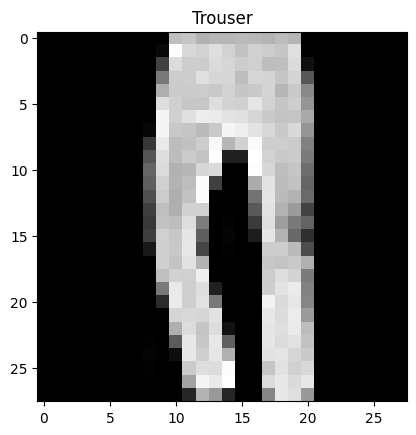

In [8]:
# 1. Fetch a random image from the available training images
ix = 24300
plt.imshow(tr_images[ix],cmap='gray')
plt.title(fmnist.classes[tr_targets[ix]])
plt.show()

In [9]:
# 2. Pass the image through the trained mode
## Preprocess the image so it goes through the same pre-processing steps we performed while building the model
img = tr_images[ix]/255
img = img.view(28*28)
img = img.to(device=device)

## Extract the probabilities associated with the various classes 
np_output = model(img).cpu().detach().numpy()
np.exp(np_output)/np.sum(np.exp(np_output))

array([1.2849629e-04, 9.9985045e-01, 4.8736410e-06, 1.2568889e-05,
       9.3952013e-07, 4.5648307e-12, 2.5255267e-06, 1.0898989e-15,
       1.4053558e-07, 2.6867159e-12], dtype=float32)

###### we can see that the highest probability is for the 1st index, which is of the Trouser class.

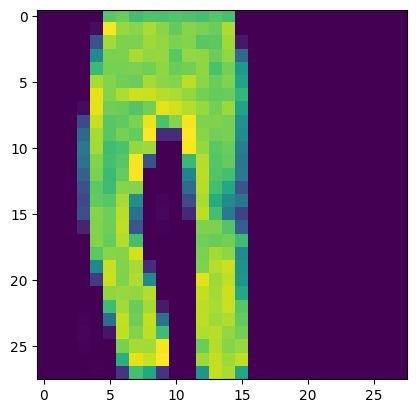

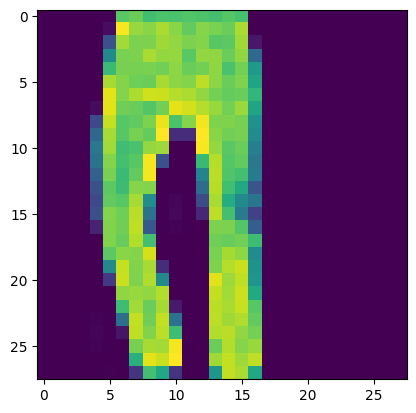

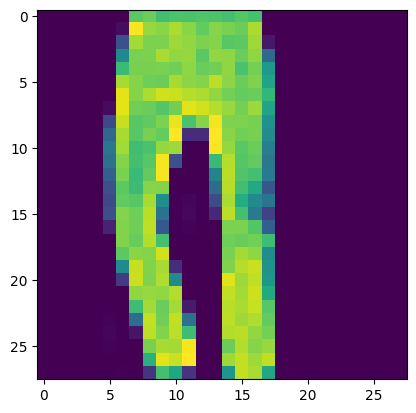

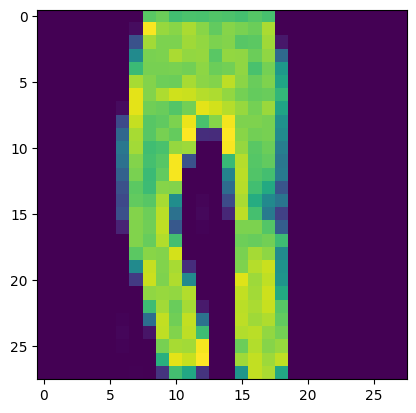

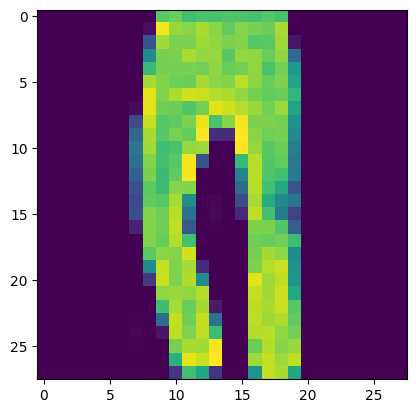

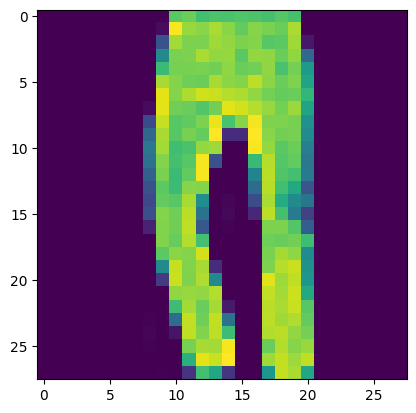

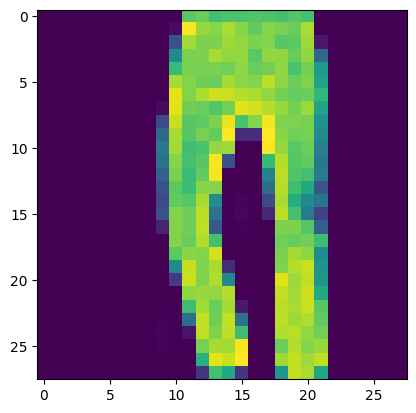

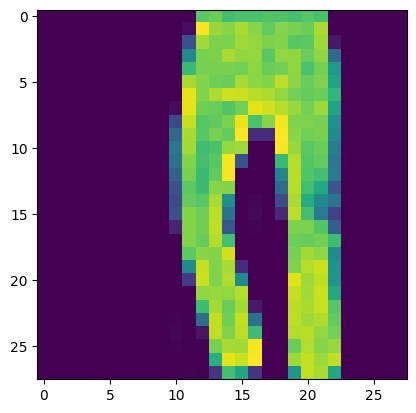

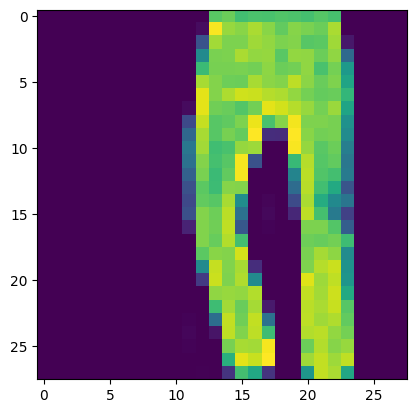

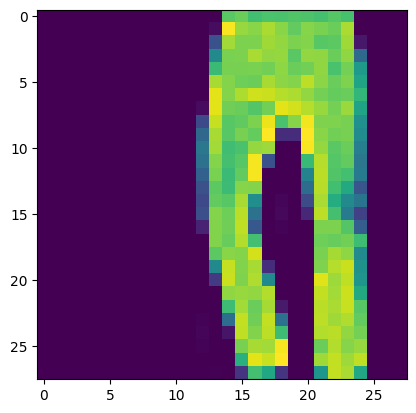

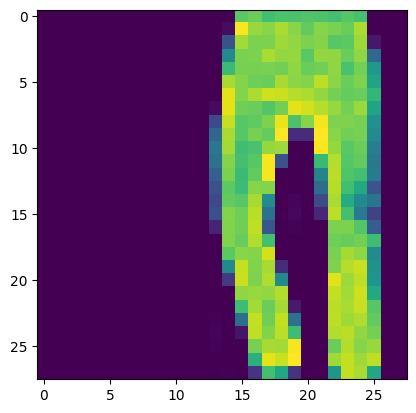

In [10]:
# 3. Translate (roll/slide) the image multiple times (one pixel at a time) from a translation of 5 pixels to the left to 5 pixels to the right and store the predictions in a list.
## Create a list that stores predictions
preds = []

## Create a loop that translates (rolls) an image from -5 pixels (5 pixels to the left) to +5 pixels (5 pixels to the right) of the original position (which is at the center of the image)
for px in range(-5,6):
  # Pre-process the image
  img = tr_images[ix]/255.
  img = img.view(28, 28)
  #img2 = np.zeros((28,28))

  # Roll the image by a value equal to px within the for loop
  img2 = np.roll(img, px, axis=1) # we specified axis=1 since we want the image pixels to be moving horizontally 
  plt.imshow(img2)
  plt.show()
  
  # Store the rolled image as a tensor object and register it to device:
  img3 = torch.Tensor(img2).view(28*28).to(device)
  
  # Pass img3 through the trained model to predict the class of the translated (rolled) image and append it to the list that is storing predictions for various translations
  np_output = model(img3).cpu().detach().numpy()
  preds.append(np.exp(np_output)/np.sum(np.exp(np_output)))

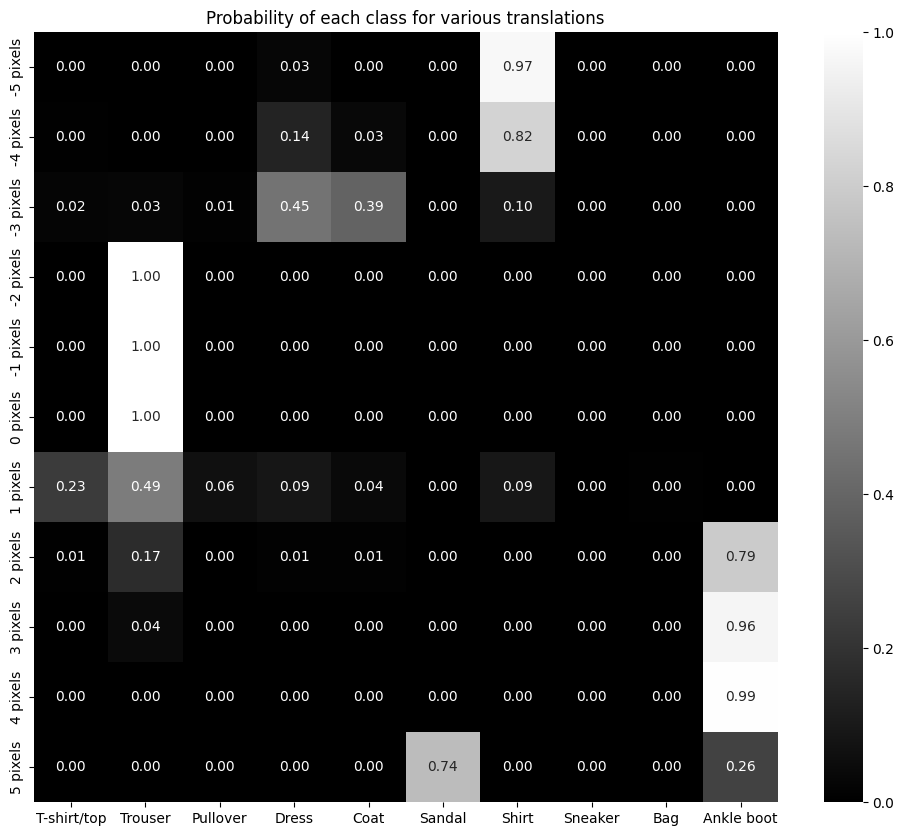

In [11]:
# 4. Visualize the predictions of the model for all the translations (-5 pixels to +5 pixels)
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')
plt.show()

* There was no change in the image's content since we only translated the images from 5 pixels to the left and 5 pixels to the right. However, the predicted class of the image changed when the translation was beyond 2 pixels. This is because while the model was being trained, the content in all the training and testing images was at the center. This differs from the preceding scenario where we tested with translated images that are off-center, resulting in an incorrectly predicted class.

    CNNs help address this problem  

---

# Building blocks of a CNN

###### Convolutional Neural Networks (CNNs) are the primary architecture for image-related tasks, overcoming limitations of deep neural networks. They excel in image classification, object detection, image segmentation, GANs, and various other image-related applications. CNNs offer diverse construction methods and numerous pre-trained models, making them crucial in various tasks involving images.

##### building blocks of a CNN, which are as follows:
* Convolutions
* Filters
* Strides and padding
* Pooling

## Convolutions


###### A convolution is basically multiplication between two matrices. As you saw in the previous chapter, matrix multiplication is a key ingredient of training a neural network. 


$$Image =
\begin{bmatrix}
1 & 2 & 3 & 4 \\
5 & 6 & 7 & 8 \\
9 & 10 & 11 & 12\\
13 & 14 & 15 & 16\\
\end{bmatrix}
Filter
\quad
\begin{bmatrix}
1 & 2 \\
3 & 4 \\
\end{bmatrix}
$$


- While performing the convolution operation, you are sliding `Filter or a Kernel` over `Original image`.  

- we are performing element to element multiplication between `Kernel` and `Original image`, as follows:

  -  1. Multiply {1,2,5,6} of the `Original image`  by {1,2,3,4} of the `Filter` : 
 1 * 1 + 2 * 2 + 5 * 3 + 6 * 4 = 44


  -  2. Multiply {2,3,6,7} of the `Original image`  by {1,2,3,4} of the `Filter` : 
 2 * 1 + 3 * 2 + 6 * 3 + 7 * 4 = 54


  -  3. Multiply {3,4,7,8} of the `Original image`  by {1,2,3,4} of the `Filter` :
  3 * 1 + 4 * 2 + 7 * 3 + 8 * 4 = 64


  -  4. Multiply {5,6,9,10} of the `Original image`  by {1,2,3,4} of the `Filter` :
  5 * 1 + 6 * 2 + 9 * 3 + 10 * 4 = 84


  -  5. Multiply  {6,7,10,11} of the `Original image`  by {1,2,3,4} of the `Filter` :
  6 * 1 + 7 * 2 + 10 * 3 + 11 * 4 = 94


  -  6. Multiply {7,8,11,12} of the `Original image`  by {1,2,3,4} of the `Filter` :
  7 * 1 + 8 * 2 + 11 * 3 + 12 * 4 = 104


  -  7. Multiply {9,10,13,14} of the `Original image`  by {1,2,3,4} of the `Filter` :
    9 * 1 + 10 * 2 + 13 * 3 + 14 * 4 = 124


  -  8. Multiply {10,11,14,15}  of the `Original image`  by {1,2,3,4} of the `Filter` :
  10 * 1 + 11 * 2 + 14 * 3 + 15 * 4 = 134


  -  9. Multiply {11,12,15,16} of the `Original image`  by {1,2,3,4} of the `Filter` :
  11 * 1 + 12 * 2 + 15 * 3 + 16 * 4 = 144


**The result of performing the preceding operations is as follows:**
$$
Convolutions Output
\begin{bmatrix}
44 & 54 & 64 \\
84 & 94 & 104 \\
124 & 134 & 144 \\
\end{bmatrix}
$$


## Filter

###### A filter is a matrix of weights that is initialized randomly at the start. The model learns the optimal weight values of a filter over increasing epochs.

- CNN Filters & Image Features:
  - More filters in a CNN allow the model to learn different features in an image.
  - Each filter identifies specific features (e.g., a cat's ears) and yields higher activation when the image area matches that feature.


- Convolution Output:
  - Applying a 2x2 filter to a 4x4 matrix produces a 3x3 output.
  - Utilizing 10 different 2x2 filters on the original image results in 10 sets of 3x3 outputs.

- Number of Output Channels:
  - The number of output channels aligns with the number of filters used.
  - For color images (with three channels), both the image and filters possess three channels, resulting in a single scalar output per convolution.

- Intermediate Layer Convolutions:
  - When convolving with an intermediate 64x112x112 output, a filter requires 64 channels to generate a scalar output.
  - Using 512 filters on the intermediate output yields a resulting shape of 512x111x111.

\begin{equation}
n_{out}=\lfloor\frac{n_{in}+2p-k}{s}\rfloor+1
\end{equation}



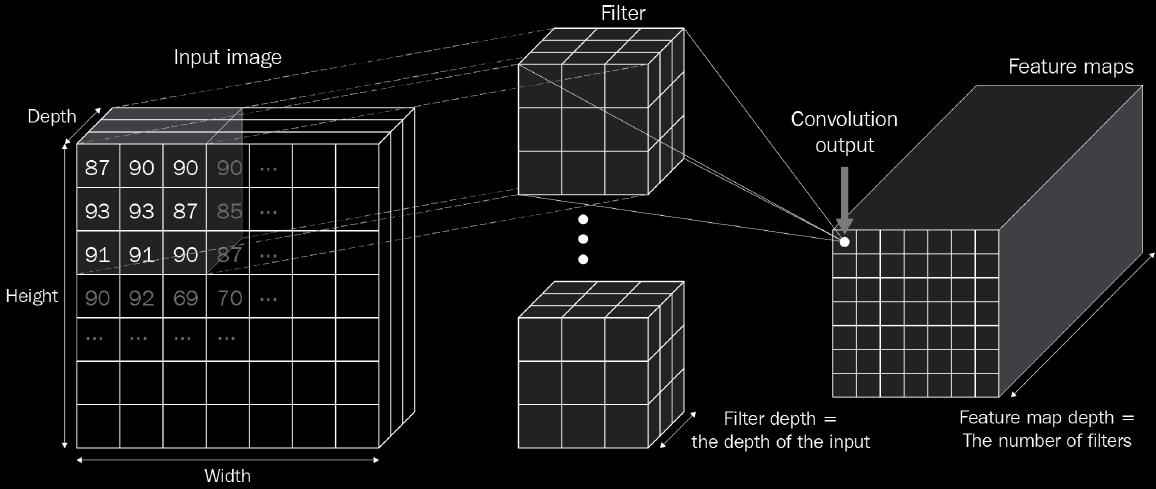

###### the input image is multiplied by the filters that have the same depth as that of the input (which the filters are convolving with) and that the number of channels in the output of a convolution is as many as there are filters.

## Strides


$$Image =
\begin{bmatrix}
1 & 2 & 3 & 4 \\
5 & 6 & 7 & 8 \\
9 & 10 & 11 & 12\\
13 & 14 & 15 & 16\\
\end{bmatrix}
Filter
\quad
\begin{bmatrix}
1 & 2 \\
3 & 4 \\
\end{bmatrix}
$$


- We'll stride `Filter or a Kernel` with a stride of 2 over `Original image` 
- The output of convolution with a stride of 2 is as follows:

  - 1. Multiply {1,2,5,6} of the `Original image`  by {1,2,3,4} of the `Filter` : 
 1 * 1 + 2 * 2 + 5 * 3 + 6 * 4 = 44


  - 3. Multiply {3,4,7,8} of the `Original image`  by {1,2,3,4} of the `Filter` :
  3 * 1 + 4 * 2 + 7 * 3 + 8 * 4 = 64


  - 7. Multiply {9,10,13,14} of the `Original image`  by {1,2,3,4} of the `Filter` :
    9 * 1 + 10 * 2 + 13 * 3 + 14 * 4 = 124


  - 9. Multiply {11,12,15,16} of the `Original image`  by {1,2,3,4} of the `Filter` :
  11 * 1 + 12 * 2 + 15 * 3 + 16 * 4 = 144


**The result of performing the preceding operations is as follows:**
$$
Convolutions Output
\begin{bmatrix}
44 & 64 \\
124 & 144 \\
\end{bmatrix}
$$


## Padding

###### In the preceding case, we could not multiply the leftmost elements of the filter by the rightmost elements of the image. If we were to perform such matrix multiplication, we would pad the image with zeros. This would ensure that we can perform element to element multiplication of all the elements within an image with a filter

Once we add padding on top of `Original Image`, the revised version of `Original Image` will look as follows:

$$Image =
\begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 2 & 3 & 4 & 0\\
0 & 5 & 6 & 7 & 8 & 0\\
0 & 9 & 10 & 11 & 12 & 0\\
0 & 13 & 14 & 15 & 16 & 0\\
0 & 0 & 0 & 0 & 0 & 0 \\ 
\end{bmatrix}
$$
###### From the preceding matrix, we can see that we have padded `Original Image` with zeros and that the convolution with `Filter` will not result in the output dimension being smaller than the input's dimension. This aspect comes in handy when we are working on residual network where we must add the output of the convolution to the original image.

## Pooling

- Pooling aggregates information in a small patch
    - Imagine a scenario where the output
of convolution activation is as follows: 
$$
\begin{bmatrix}
1 & 2 \\
3 & 4 \\
\end{bmatrix}
$$
- The max pooling for this patch is 4. Here, we have considered the elements in this pool of elements and have taken the maximum value across all the elements present.

- understand the max pooling for a `Original Image`:
$$
\begin{bmatrix}
1 & 2 & 3 & 4 \\
5 & 6 & 7 & 8 \\
9 & 10 & 11 & 12\\
13 & 14 & 15 & 16\\
\end{bmatrix}
$$
- If the pooling stride has a length of 2, the max pooling operation is calculated as follows, where we divide the input image by a stride of 2
(that is, we have divided the image into 2 x 2 divisions)

- The maximum values in the pool of elements are as follows:
$$
\begin{bmatrix}
6 & 8 \\
14 & 16 \\
\end{bmatrix}
$$
- Other variants of pooling are sum and average pooling
    However, in practice, max pooling is used more often.
    
- ###### Note that by the end of performing the convolution and pooling operations, the size of the original matrix is reduced from 4 x 4 to 2 x 2. In a realistic scenario, if the original image is of shape 200 x 200 and the filter is of shape 3 x 3, the output of the convolution operation would be 198 x 198. After that, the output of the pooling operation with a stride of 2 is 99 X 99.

## Putting them all together

- the flatten layer (fully connected layer)
    - The output of flattening the pooling layer is as follows:
    {6,8,14,16}

    - Once the flatten layer's (fully connected layer) values have been obtained, we can pass it through the hidden layer and then obtain the output for predicting the class of an image.

**The overall flow of a CNN is as follows:**

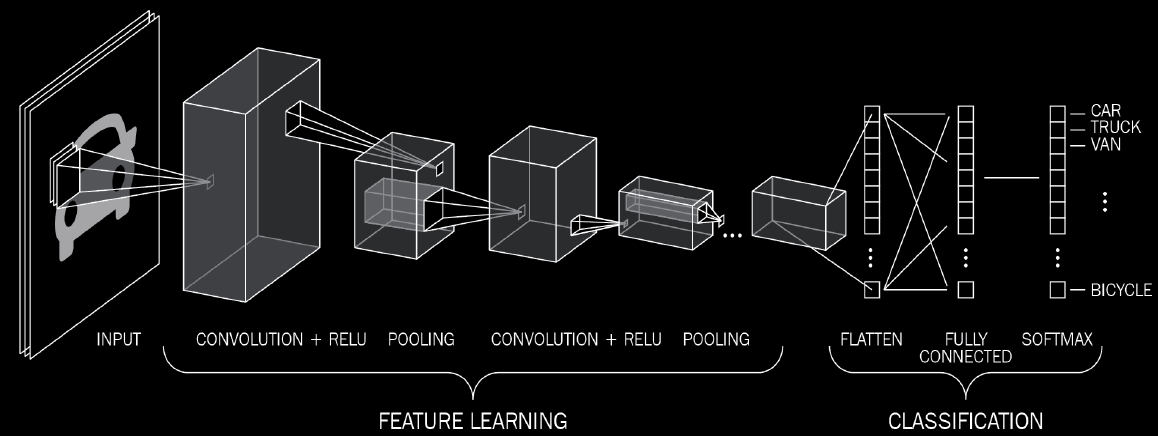

- Convolution and Pooling:
    - Image passed through convolution using multiple filters and pooling.
    - Process may repeat to extract features and reduce dimensionality before flattening.

- Feature Learning:
    - Core operations are convolution and pooling.
    - Filters extract features, while pooling aggregates information, reducing nodes at the flatten layer.
    

- Dimension Reduction:
    - Convolution and pooling lead to a flattened layer that represents the image in a much smaller format than the original.
    - Crucial for manageable computation due to reduced dimensionality.

- Classification Process:
    - Final stage involves classification similar to traditional neural networks.
    - Includes hidden layers and an output layer to classify features extracted in earlier stages.


###### - Directly flattening a large input image without this process results in a vast number of parameters, demanding heavy computation.


---

# How convolution and pooling help in image translation



1. Pooling Abstraction: 
   - Pooling creates an abstracted view of image regions, beneficial for image translation tasks.

2. Effect of Image Translation: 
   - Convolution, activation, and pooling reduce the image's dimension, storing primary information in fewer pixels.

3. Consistency in Pooled Information: 
   - Pooled information within a pixel remains consistent despite image translation, as it captures the maximum value in a given region.

4. Receptive Field in Convolution and Pooling: 
   - Multiple convolution-pooling operations reduce a 100x100 image to a 25x25 output, with each cell in the output corresponding to a 4x4 portion of the original image.


###### because of the convolution and pooling operations, each cell in the resulting image corresponds to a patch of the original image.


----

# Implementing a CNN

###### A CNN is one of the foundational blocks of computer vision techniques, and it is important for you to have a solid understanding of how they work. While we already know that a CNN constitutes convolution, pooling, flattening, and then the final classification layer

---
# Building a CNN-based architecture

In [1]:
# 1. First, we need to import the relevant libraries 
import torch
from torch import nn
from torchvision import datasets
from torchsummary import summary
from torch.utils.data import DataLoader,Dataset,TensorDataset
from torch.optim import Adam , SGD

import numpy as np
import matplotlib.pyplot as plt

## define cuda 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
# 2. Then, we need to create the dataset
X_train = torch.tensor(
                        [[[[1,2,3,4],
                          [2,3,4,5],
                          [5,6,7,8],
                          [1,3,4,5]]],
                         [[[-1,2,3,-4],
                          [2,-3,4,5],
                          [-5,6,-7,8],
                          [-1,-3,-4,-5]]]]).to(device).float()

# scaling the input dataset so that it has a range between -1 to +1
X_train /= 8

y_train = torch.tensor([0,1]).to(device).float()

**`Note`** that PyTorch expects inputs to be of the shape N x C x H x W, where N is the number (batch size) of images, C is the number of channels, H is the height, and W is the width of the image.

###### The shape of the input dataset is (2,1,4,4) since there are two data points, where each is 4 x 4 in shape and has 1 channel.

In [14]:
# 3. Define the model architecture
def get_model():
    model =nn.Sequential(
                        nn.Conv2d(in_channels = 1,out_channels = 1,kernel_size=3),
                        nn.MaxPool2d(kernel_size=2),
                        nn.ReLU(),
                        nn.Flatten(),
                        nn.Linear(1,1),
                        nn.Sigmoid()).to(device=device)
    loss_fn = nn.BCELoss()
    optimizer = Adam(model.parameters(),lr=1e-3)
    return model,loss_fn,optimizer

# 4. Summarize the architecture of the model 
model , loss_fn , optimizer = get_model()
summary(model=model,input_data=X_train)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 1, 2, 2]             10
├─MaxPool2d: 1-2                         [-1, 1, 1, 1]             --
├─ReLU: 1-3                              [-1, 1, 1, 1]             --
├─Flatten: 1-4                           [-1, 1]                   --
├─Linear: 1-5                            [-1, 1]                   2
├─Sigmoid: 1-6                           [-1, 1]                   --
Total params: 12
Trainable params: 12
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 1, 2, 2]             10
├─MaxPool2d: 1-2                         [-1, 1, 1, 1]             --
├─ReLU: 1-3                              [-1, 1, 1, 1]             --
├─Flatten: 1-4                           [-1, 1]                   --
├─Linear: 1-5                            [-1, 1]                   2
├─Sigmoid: 1-6                           [-1, 1]                   --
Total params: 12
Trainable params: 12
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

##### the reason why each layer contains so manyparameters.:
- **Kernel size:** 3x3
- **Output channels:** 1
- **Input channels:** 1
- **Operation:** Convolution with a 3x3 filter on a 1x4x4 input, resulting in a 1x2x2 output.

##### Parameter Calculation:
- **Convolutional Layer Parameters:** 10 (9 weight parameters + 1 bias)
- **MaxPool2d, ReLU, and Flatten Layers:** No parameters as they're operations on the convolutional layer output.
- **Linear Layer Parameters:** 2 (1 weight and 1 bias)

##### Total Parameters:
- **Convolutional Layer:** 10 parameters
- **Linear Layer:** 2 parameters
- **Total:** 12 parameters in the entire network (10 from convolution, 2 from the linear layer).


In [15]:
# 5. Train the model
## Define the function that will train on batches of data
def train_batch(x, y, model , opt , loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction.squeeze(0),y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

## Define the training DataLoader
# TensorDataset: provides an object that corresponds to theinput data.
trn_dl = DataLoader(TensorDataset(X_train,y_train))

## Train the model over 2,000 epochs
for epoch in range(2000):
    for ix, batch in enumerate(trn_dl):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)

In [16]:
# 6. Perform a forward pass on top of the first data point
model(X_train[:1])

tensor([[0.1955]], device='cuda:0', grad_fn=<SigmoidBackward0>)

---

# Forward propagating the output in Python

###### We don't need to perform the following steps in a real-world scenario:

In [18]:
# 1. Extract the weights and biases of the convolution and linear layers of the architecture that's been defined
## Extract the various layers of the model
list(model.children())

[Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 ReLU(),
 Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=1, out_features=1, bias=True),
 Sigmoid()]

In [24]:
## Extract the layers among all the layers of the model that have the weight attribute associated with them
(cnn_w , cnn_b) , (lin_w , lin_b) = [(layer.weight.data , layer.bias.data) for layer in list(model.children()) if hasattr(layer , 'weight')]
#  hasattr(layer,'weight') returns a boolean, regardless of whether the layer contains the weight attribute.

In [25]:
(cnn_w , cnn_b) , (lin_w , lin_b)

((tensor([[[[-0.3798,  0.1915,  0.2855],
            [ 0.2505, -0.5299, -0.0172],
            [-1.1055,  0.8153, -1.1733]]]], device='cuda:0'),
  tensor([0.5496], device='cuda:0')),
 (tensor([[2.2360]], device='cuda:0'), tensor([-1.4149], device='cuda:0')))

- The shape of `cnn_w` is 1 x 1 x 3 x 3 since we have initialized one filter, which has one channel and a dimension of 3 x 3. `cnn_b` has a shape of 1 as it corresponds to one filter.

In [28]:
# 2. To perform the cnn_w convolution operation over the input value, we must initialize a matrix of zeros for sumproduct (sumprod) where the height is input height - filter height + 1 and the width is width - filter width + 1

h_im, w_im = X_train.shape[2:]   # Extracting the height and width of the input X_train
h_conv, w_conv = cnn_w.shape[2:] # Extracting the height and width of the cnn_w

# Calculating the dimensions of the resulting feature map after convolution
sumprod = torch.zeros((h_im - h_conv + 1, w_im - w_conv + 1))

# 3. Now, let's fill sumprod by convoluting the filter (cnn_w) across the first input and summing up the filter bias term (cnn_b) after reshaping the filter shape from a 1 x 1 x 3 x 3 shape to a 3 x 3 shape
for i in range(h_im - h_conv + 1):
    for j in range(w_im - w_conv + 1):
        img_subset = X_train[0, 0, i:(i+3), j:(j+3)]
        model_filter = cnn_w.reshape(3,3)
        val = torch.sum(img_subset*model_filter) + cnn_b
        sumprod[i,j] = val

###### In the preceding code, img_subset stores the portion of the input that we would be convolving with the filter and hence we stride through it across the possible columns and then rows.
###### Furthermore, given that the input is 4 x 4 in shape and the filter is 3 x 3 in shape, the output is 2 x 2 in shape

In [29]:
sumprod

tensor([[-0.5938, -0.8017],
        [-0.0058, -0.3519]])

In [30]:
# 4. Perform the ReLU operation on top of the output and then fetch the maximum value of the pool (MaxPooling)
sumprod.clamp_min_(0) # set or clamping all negative values in a tensor to zero.

tensor([[0., 0.],
        [0., 0.]])

In [32]:
## The output of the pooling layer can be calculated like so
pooling_layer_output = torch.max(sumprod)
pooling_layer_output

tensor(0.)

In [33]:
# 5. Pass the preceding output through linear activation
intermediate_output_value = pooling_layer_output*lin_w+lin_b
intermediate_output_value

tensor([[-1.4149]], device='cuda:0')

In [37]:
# 6. Pass the output through the sigmoid operation
sig = nn.Sigmoid()
sig(intermediate_output_value)

tensor([[0.1955]], device='cuda:0')

---
# Classifying images using deep CNNs

In [1]:
# 1. Import the necessary packages
from torchvision import datasets
import torch 
import torch.nn as nn 
from torchsummary import summary
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
data_folder = 'Dataset'
fmnist = datasets.FashionMNIST(root=data_folder,download=True,train=True)
val_fmnist = datasets.FashionMNIST(root=data_folder,download=True, train=False)
tr_images = fmnist.data
tr_targets = fmnist.targets
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [18]:
# 2. Define Fashion-MNIST dataset class 
class FMNISTDataset(Dataset):
    def __init__(self,x,y) :
        self.x = (x.float()/255).view(-1,1,28,28)
        self.y =y
    def __getitem__(self, ix) :
        x, y = self.x[ix],self.y[ix]
        return x.to(device),y.to(device)
    def __len__(self):
        return len(self.x)
    
# 3. Define CNN model architecture 
def get_model():
    model = nn.Sequential(
                    nn.Conv2d(in_channels=1,out_channels=64,kernel_size=3),
                    nn.MaxPool2d(kernel_size=2),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3),
                    nn.MaxPool2d(2),
                    nn.ReLU(),
                    nn.Flatten(),
                    nn.Linear(in_features=3200,out_features=256),
                    nn.ReLU(),
                    nn.Linear(in_features=256,out_features=10)
                    ).to(device=device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(),lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x,y,model,opt,loss_fn):
    prediction = model(x)
    batch_loss =loss_fn(prediction,y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.inference_mode():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()
@torch.inference_mode()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

def get_data():
    train = FMNISTDataset(tr_images, tr_targets)     
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)     
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

In [19]:
## Create a summary  model 
model , loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8


### Layer 1
- **Description:** 64 filters with a kernel size of 3.
- **Parameters:**
  - Weights: 64 filters * (3 * 3) = 576 weights
  - Biases: 64 biases
- **Total Parameters:** 640

### Layer 4
- **Description:** 128 filters with a kernel size of 3, connected to the previous layer.
- **Parameters:**
  - Weights: 128 filters * (64 * 3 * 3) = 73,728 weights
  - Biases: 128 biases
- **Total Parameters:** 73,856

### Layer 8
- **Description:** A layer with 3,200 nodes connected to another layer with 256 nodes.
- **Parameters:**
  - Weights: 3,200 nodes * 256 nodes = 819,200 weights
  - Biases: 256 biases
- **Total Parameters:** 819,456

### Layer 10
- **Description:** A layer with 256 nodes connected to a layer with 10 nodes.
- **Parameters:**
  - Weights: 256 nodes * 10 nodes = 2,560 weights
  - Biases: 10 biases
- **Total Parameters:** 2,570


In [20]:
trn_dl, val_dl = get_data()
model , loss_fn, optimizer = get_model()

In [21]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(trn_dl):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(trn_dl):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(val_dl):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


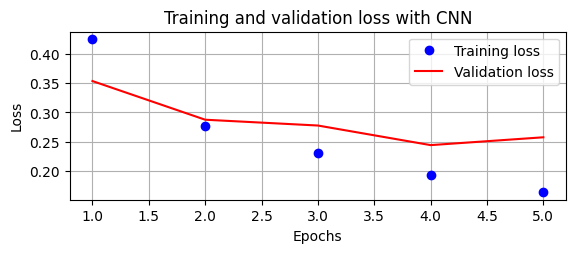

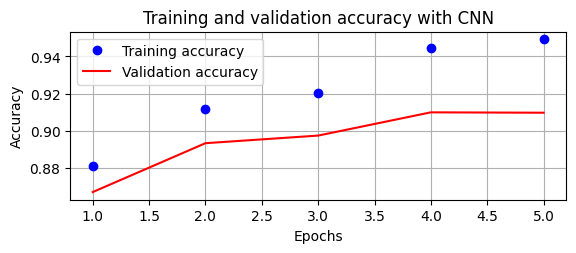

In [22]:
epochs = np.arange(5)+1
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid('off')
plt.show()

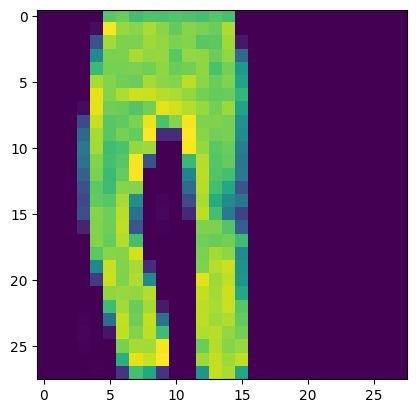

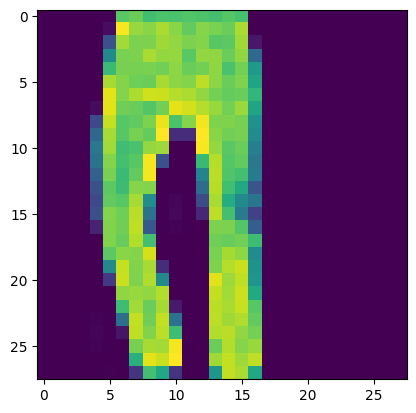

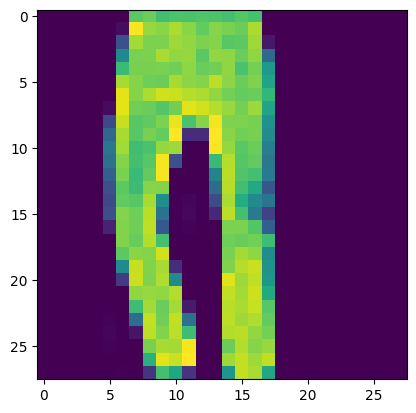

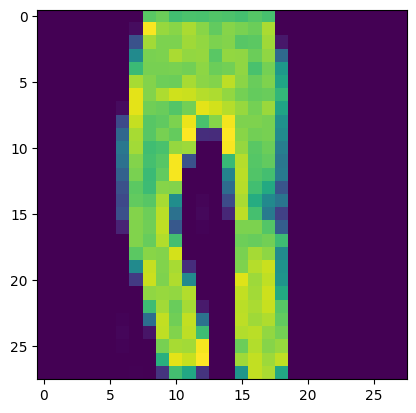

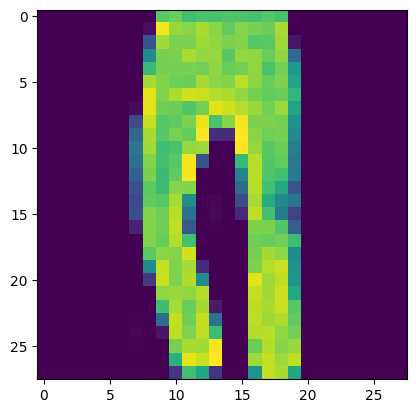

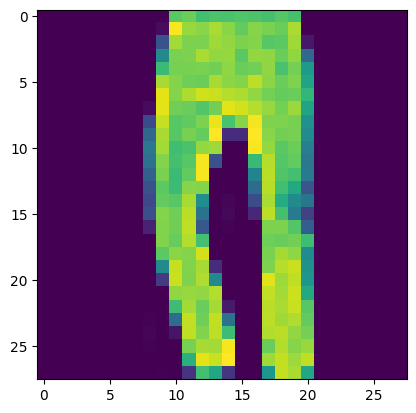

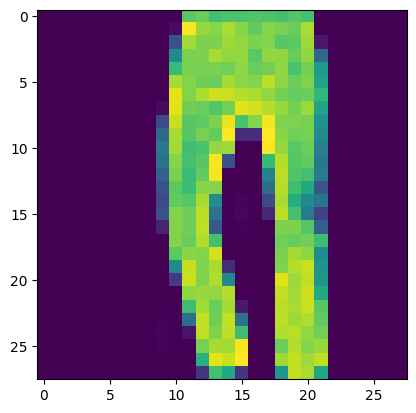

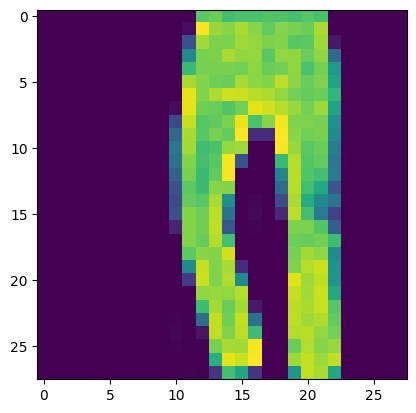

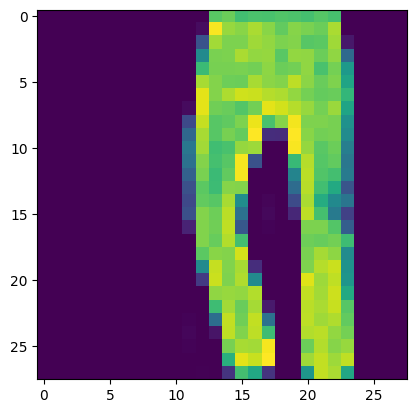

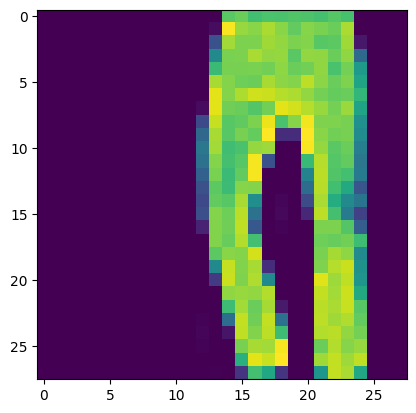

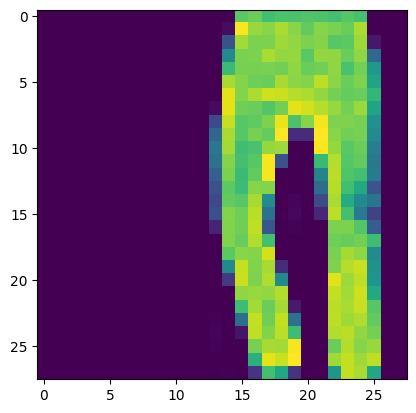

In [23]:
# 1. Translate the image between -5 pixels to +5 pixels and predict its class
preds = []
ix = 24300
for px in range(-5,6):
    img = tr_images[ix]/255.
    img = img.view(28, 28)
    img2 = np.roll(img, px, axis=1)
    plt.imshow(img2)
    plt.show()
    img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
    np_output = model(img3).cpu().detach().numpy()
    preds.append(np.exp(np_output)/np.sum(np.exp(np_output)))

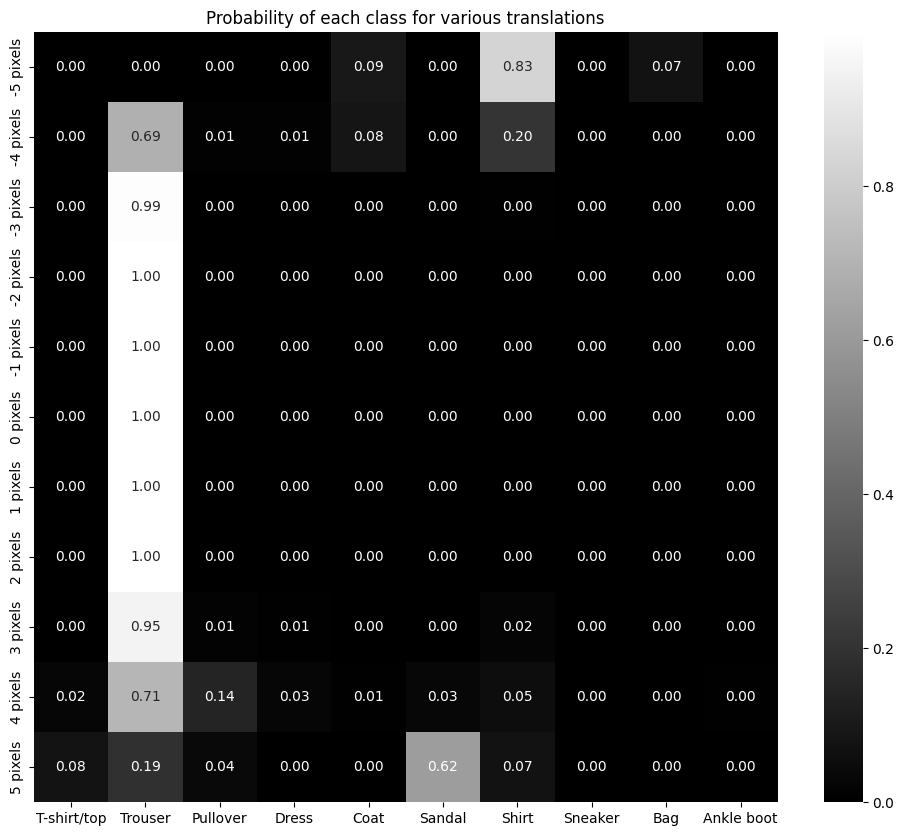

In [25]:
# 2. Plot the probability of the classes across various translations
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds).reshape(11,10), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')
plt.show()

**`Note`** that in this scenario, even when the image was translated by 4 pixels, the prediction was correct, while in the scenario where we did not use a CNN, the prediction was incorrect when the image was translated by 4 pixels. Furthermore, when the image was translated by 5 pixels, the probability of "Trouser" dropped considerably.

---
# Implementing data augmentation

#### Overcoming Image Translation Challenges in CNNs

In previous scenarios, CNNs have demonstrated the ability to predict the class of an image accurately within a certain limit of translation, typically up to 5 pixels. However, when the translation exceeds this range, the probability of predicting the correct class significantly diminishes.

To address this limitation, we aim to ensure accurate class prediction even when the image is translated by a substantial amount.

##### Approach to Enhance Translation Robustness

To tackle this challenge, we'll modify the neural network training process by introducing a deliberate translation of input images by 10 pixels randomly in both left and right directions. By applying this strategy, the same image will be processed as distinct images during different passes through the network due to varying amounts of translation applied in each pass.

This technique aims to train the neural network to recognize and classify images accurately, even when subjected to considerable translation. By exposing the network to differently translated versions of the same image, it learns to generalize and make correct predictions, regardless of the level of translation applied to the input images.


---
# Image augmentations

- In the real world, we might encounter various scenarios, such as the following
    - **Rotations:** Slight changes in image orientation.
    - **Scaling:** Image zooming in/out, altering dimensions.
    - **Noise:** Irregularities affecting image clarity.
    - **Brightness:** Variations impacting overall visibility.
    - **Flipping:** Mirroring alters spatial arrangement.
    - **Shearing:** One side of an image twists or skews.

###### A neural network that does not take the preceding scenarios into consideration won't provide accurate results

###### Image augmentations come in handy in scenarios where we create more images from a given image. Each of the created images can vary in terms of rotation, translation, scale, noise, and brightness. Furthermore, the extent of the variation in each of these parameters can also vary (for example, translation of a certain image in a given iteration can be +10 pixels, while in a different iteration, it can be -5 pixels).

**The augmenters class in the imgaug package has useful utilities for performing these augmentations.** 

- Some of the most prominent augmentation techniques are as follows:
    - Affine transformations
    - Change brightness
    - Add noise

###### **`Note`** that PyTorch has a handy image augmentation pipeline in the form of torchvision.transforms. However, we still opted to introduce a different library primarily because of the larger variety of options imgaug contains

### 1. Affine transformations

Affine transformations involve translating, rotating, scaling, and shearing an image. They can be performed in code using the Affine method that's present in the augmenters class.

- Some of the important parameters in the Affine method are as follows:
    - `scale` specifies the amount of zoom that is to be done for the image
    - `translate_percent` specifies the amount of translation as a percentage of the image's height and width
    - `translate_px` specifies the amount of translation as an absolute number of pixels
    - `rotate` specifies the amount of rotation that is to be done on the image
    - `shear` specifies the amount of rotation that is to be done on part of the image

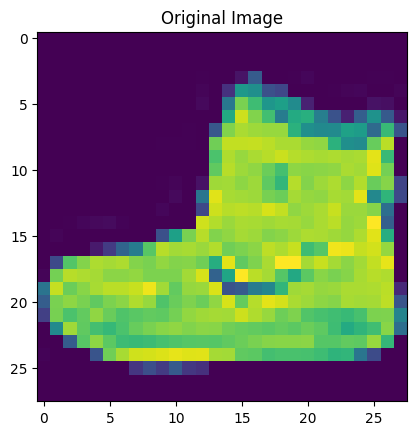

In [2]:
# 1. Download images from the Fashion-MNIST dataset
data_folder = 'Dataset'
fmnist = datasets.FashionMNIST(root=data_folder , download=True , train=True)

# 2. Fetch an image from the downloaded datase
tr_images = fmnist.data
tr_targets = fmnist.targets

# 3. Let's plot the first image
plt.imshow(tr_images[0])
plt.title('Original Image')
plt.show()

**Perform scaling on top of the imag**

In [3]:
def to_numpy(tensor):
    return tensor.cpu().detach().numpy()

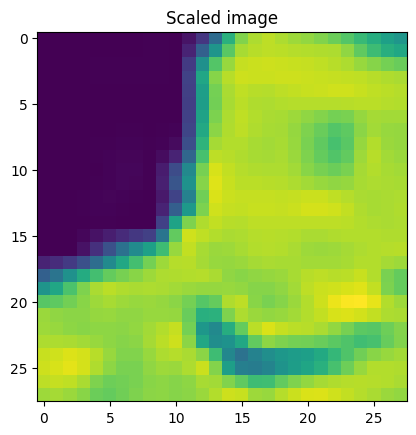

In [5]:
# 1. Define an object that performs scaling
from imgaug import augmenters as iaa
aug = iaa.Affine(scale=2)

# 2. augment the image using the augment_image method
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title('Scaled image')
plt.show()

- Zooming into the image has caused pixel loss as the output shape remains unchanged, leading to the removal of some pixels from the original image.

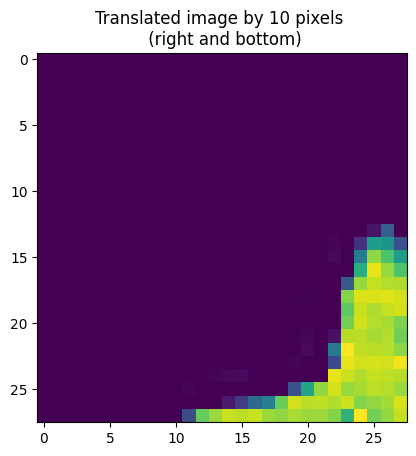

In [9]:
#  translated  image by a certain number of pixels 
aug = iaa.Affine(translate_px=10)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title('Translated image by 10 pixels \n (right and bottom)')
plt.show()

- translation by 10 pixels has happened across both the x and y axes.

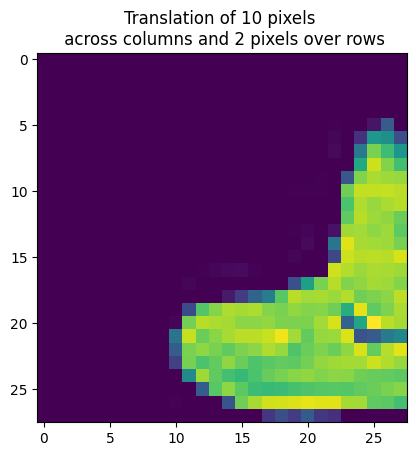

In [10]:
# If we want to perform translation more in one axis and less in the other axis, we must specify the amount of translation we want in each axis
aug = iaa.Affine(translate_px={'x':10,'y':2})
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title('Translation of 10 pixels \n across columns and 2 pixels over rows')
plt.show()

- Translation occurred more frequently across columns than rows, leading to a partial cropping of the image.

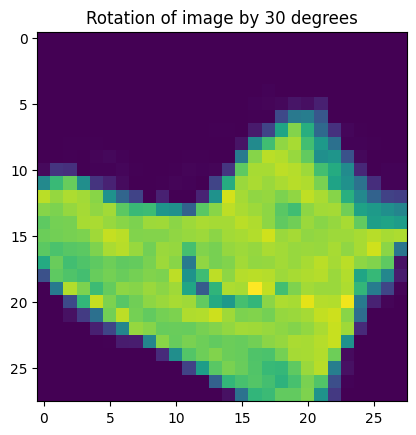

In [11]:
aug = iaa.Affine(rotate=30)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title('Rotation of image by 30 degrees')
plt.show()

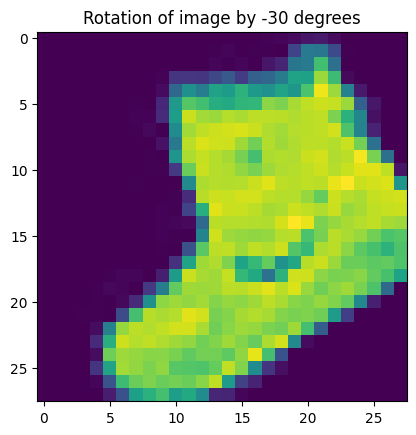

In [12]:
aug = iaa.Affine(rotate=-30)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title('Rotation of image by -30 degrees')
plt.show()

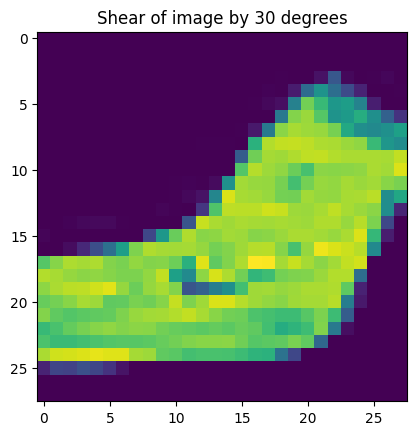

In [13]:
aug = iaa.Affine(shear=30)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title('Shear of image by 30 degrees')
plt.show()

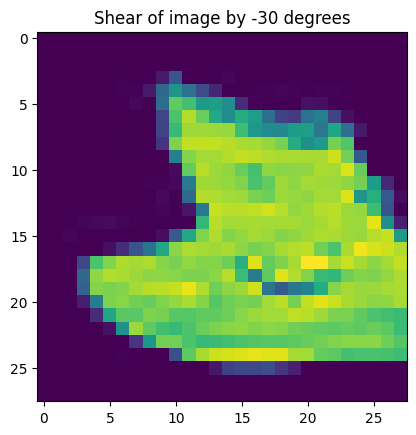

In [14]:
aug = iaa.Affine(shear=-30)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title('Shear of image by -30 degrees')
plt.show()

- In the majority of the preceding outputs, we can see that certain pixels were cropped out of the image post-transformation.
- fit_output is a parameter that can help with the preceding scenario. By default, it is set to False.

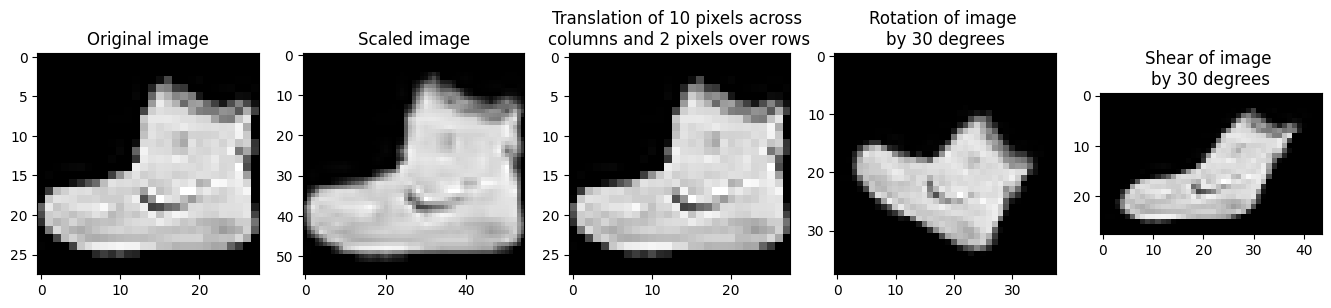

In [15]:
# how the preceding outputs vary when we specify fit_output as True 
plt.figure(figsize=(20,20))
plt.subplot(161)
plt.imshow(tr_images[0], cmap='gray')
plt.title('Original image')
plt.subplot(162)
aug = iaa.Affine(scale=2, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Scaled image')
plt.subplot(163)
aug = iaa.Affine(translate_px={'x':10,'y':2}, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Translation of 10 pixels across \ncolumns and 2 pixels over rows')
plt.subplot(164)
aug = iaa.Affine(rotate=30, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image \nby 30 degrees')
plt.subplot(165)
aug = iaa.Affine(shear=30, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Shear of image \nby 30 degrees')
plt.show()

###### we can see that the original image hasn't been cropped and that the size of the augmented image increased to account for the augmented image not being cropped (in the scaled image's output or when rotating the image by 30 degrees). Furthermore, we can also see that the activation of the `fit_output` parameter has negated the translation that we expected in the translation of a 10-pixel image

- when the size of the augmented image increases (for example, when the image is rotated), we need to figure out how the new pixels that are not part of the original image should be filled in.
- ###### The `cval` parameter solves this issue. It specifies the pixel value of the new pixels that are created when `fit_output` is True. In the preceding code, cval is filled with a default value of 0, which results in black pixels.

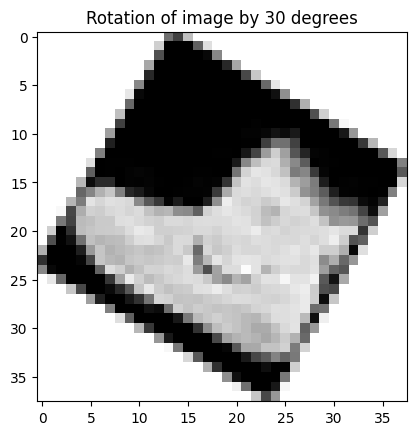

In [17]:
# changing the cval parameter to a value of 255
aug = iaa.Affine(rotate=30 , fit_output=True , cval=255)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])),cmap='gray')
plt.title('Rotation of image by 30 degrees')
plt.show()

In the preceding image, the new pixels have been filled with a pixel value of 255, which corresponds to the color white.


Furthermore, there are different modes we can use to fill the values of newly created pixels. 
- These values, which are for the mode parameter, are as follows:
    - `constant`: Pads with a constant value.
    - `edge`: Pads with the edge values of the array.
    - `symmetric`: Pads with the reflection of the vector mirrored along the edge of the array.
    - `reflect`: Pads with the reflection of the vector mirrored on the first and
    - `last` values of the vector along each axis.
    - `wrap`: Pads with the wrap of the vector along the axis.
- The initial values are used to pad the end, while the end values are used to pad the beginning.

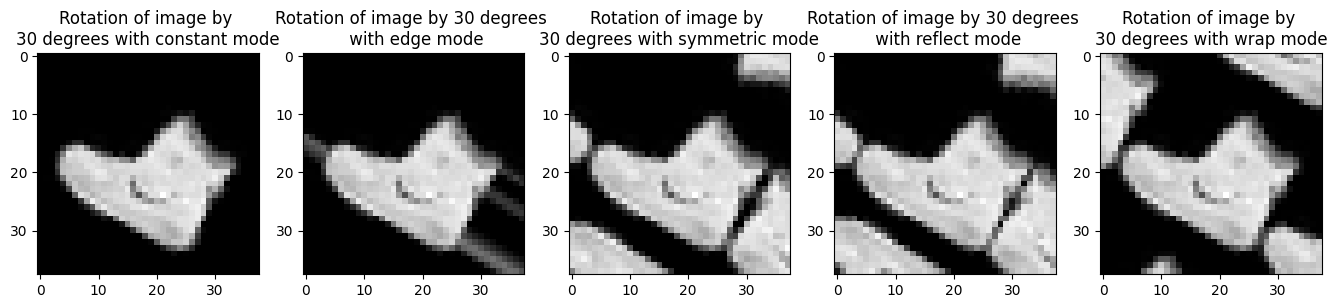

In [18]:
plt.figure(figsize=(20,20))
plt.subplot(161)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by \n30 degrees with constant mode')
plt.subplot(162)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='edge')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by 30 degrees \n with edge mode')
plt.subplot(163)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='symmetric')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by \n30 degrees with symmetric mode')
plt.subplot(164)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='reflect')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by 30 degrees \n with reflect mode')
plt.subplot(165)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='wrap')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by \n30 degrees with wrap mode')
plt.show()

 we can see that for our current scenario based on the Fashion-MNIST dataset, it is more desirable to use the constant mode for data augmentation.

###### we have specified that the translation needs to be a certain number of pixels. Similarly, we have specified that the rotation angle should be of a specific degree. However, in practice, it becomes difficult to specify the exact angle that an image needs to be rotated by.

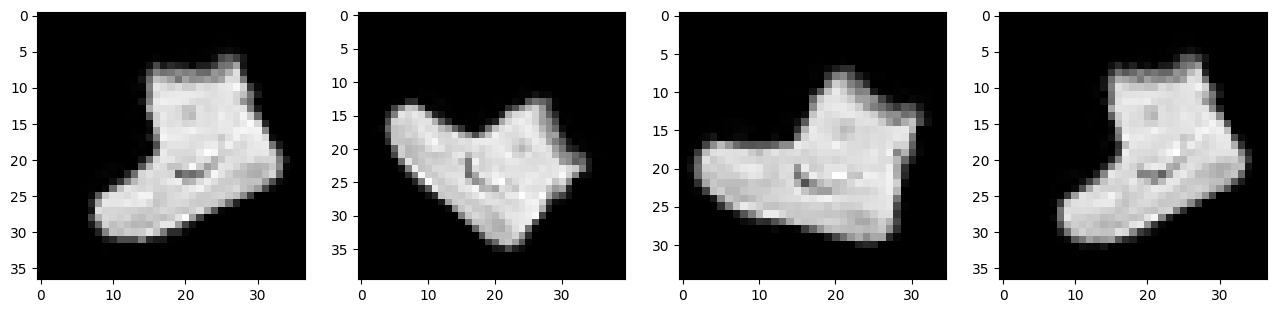

In [19]:
#  provided a range that the image will be rotated by
plt.figure(figsize=(20,20))
plt.subplot(151)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.subplot(152)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.subplot(153)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.subplot(154)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.show()

###### the same image was rotated differently in different iterations because we specified a range of possible rotation angles in terms of the upper and lower bounds of the rotation. Similarly, we can randomize augmentations when we are translating or sharing an image.

### 2. Changing the brightness